In [1]:
%run supportvectors-common.ipynb



<div style="color:#aaa;font-size:8pt">
<hr/>

 </blockquote>
 <hr/>
</div>



#  Gradient Descent





We studied gradient descent in the theory sessions, as an effective way to optimize the loss function, and thus make the algorithm learn an effective model for estimations on a dataset $\mathscr{D}$ comprised of predictors and response. In this notebook, we will do the process of learning an effective model through  gradient descent, by working out the steps on our own. For simplicity, we will consider the case of ordinary least squares regression (simple linear regression).

In a prior notebook, `old-faithful-geyser.ipynb`, we explored *old faithful geyser* data, and found that a linear regression model works quite effectively in modeling the eruptions.

Let us repeat the exercise, but write our own code for the gradient descent based learning.

## Load and explore the data

Let us load the data from the specified url, into a Pandas dataframe. Looking at the github site mentioned above, we see that the dataset is stored as a CSV file, and can be accessed at the url:
https://raw.githubusercontent.com/supportvectors/ml-100/master/old-faithful-geyser.csv

Let us, therefore, load it, and perform some basic explorations. *Note: this data file has the columns as tab-separated.*

In [14]:
source = 'https://raw.githubusercontent.com/supportvectors/ml-100/master/old-faithful-geyser.csv'
raw_data = pd.read_csv(source, sep='\t')
scaler = StandardScaler()
scaled = scaler.fit_transform(raw_data)
data = pd.DataFrame(data={'eruptions':scaled[:, 0], 'waiting': scaled[:,1]})
data.describe()

,eruptions,waiting
count,2.720e+02,2.720e+02
mean,5.151e-16,4.398e-16
std,1.002e+00,1.002e+00
min,-1.657e+00,-2.056e+00
25%,-1.163e+00,-9.504e-01
50%,4.496e-01,3.760e-01
75%,8.483e-01,8.182e-01
max,1.415e+00,1.850e+00


## Data Visualization

To whet our recollection of the key data exploration findings, let us mention some of the plots of the dataset.

Let us first visualize a scatter plot of the data and look at the histogram of the features. Finally, let us pull of this together with a kernel density plot, into a single plot with subplots.

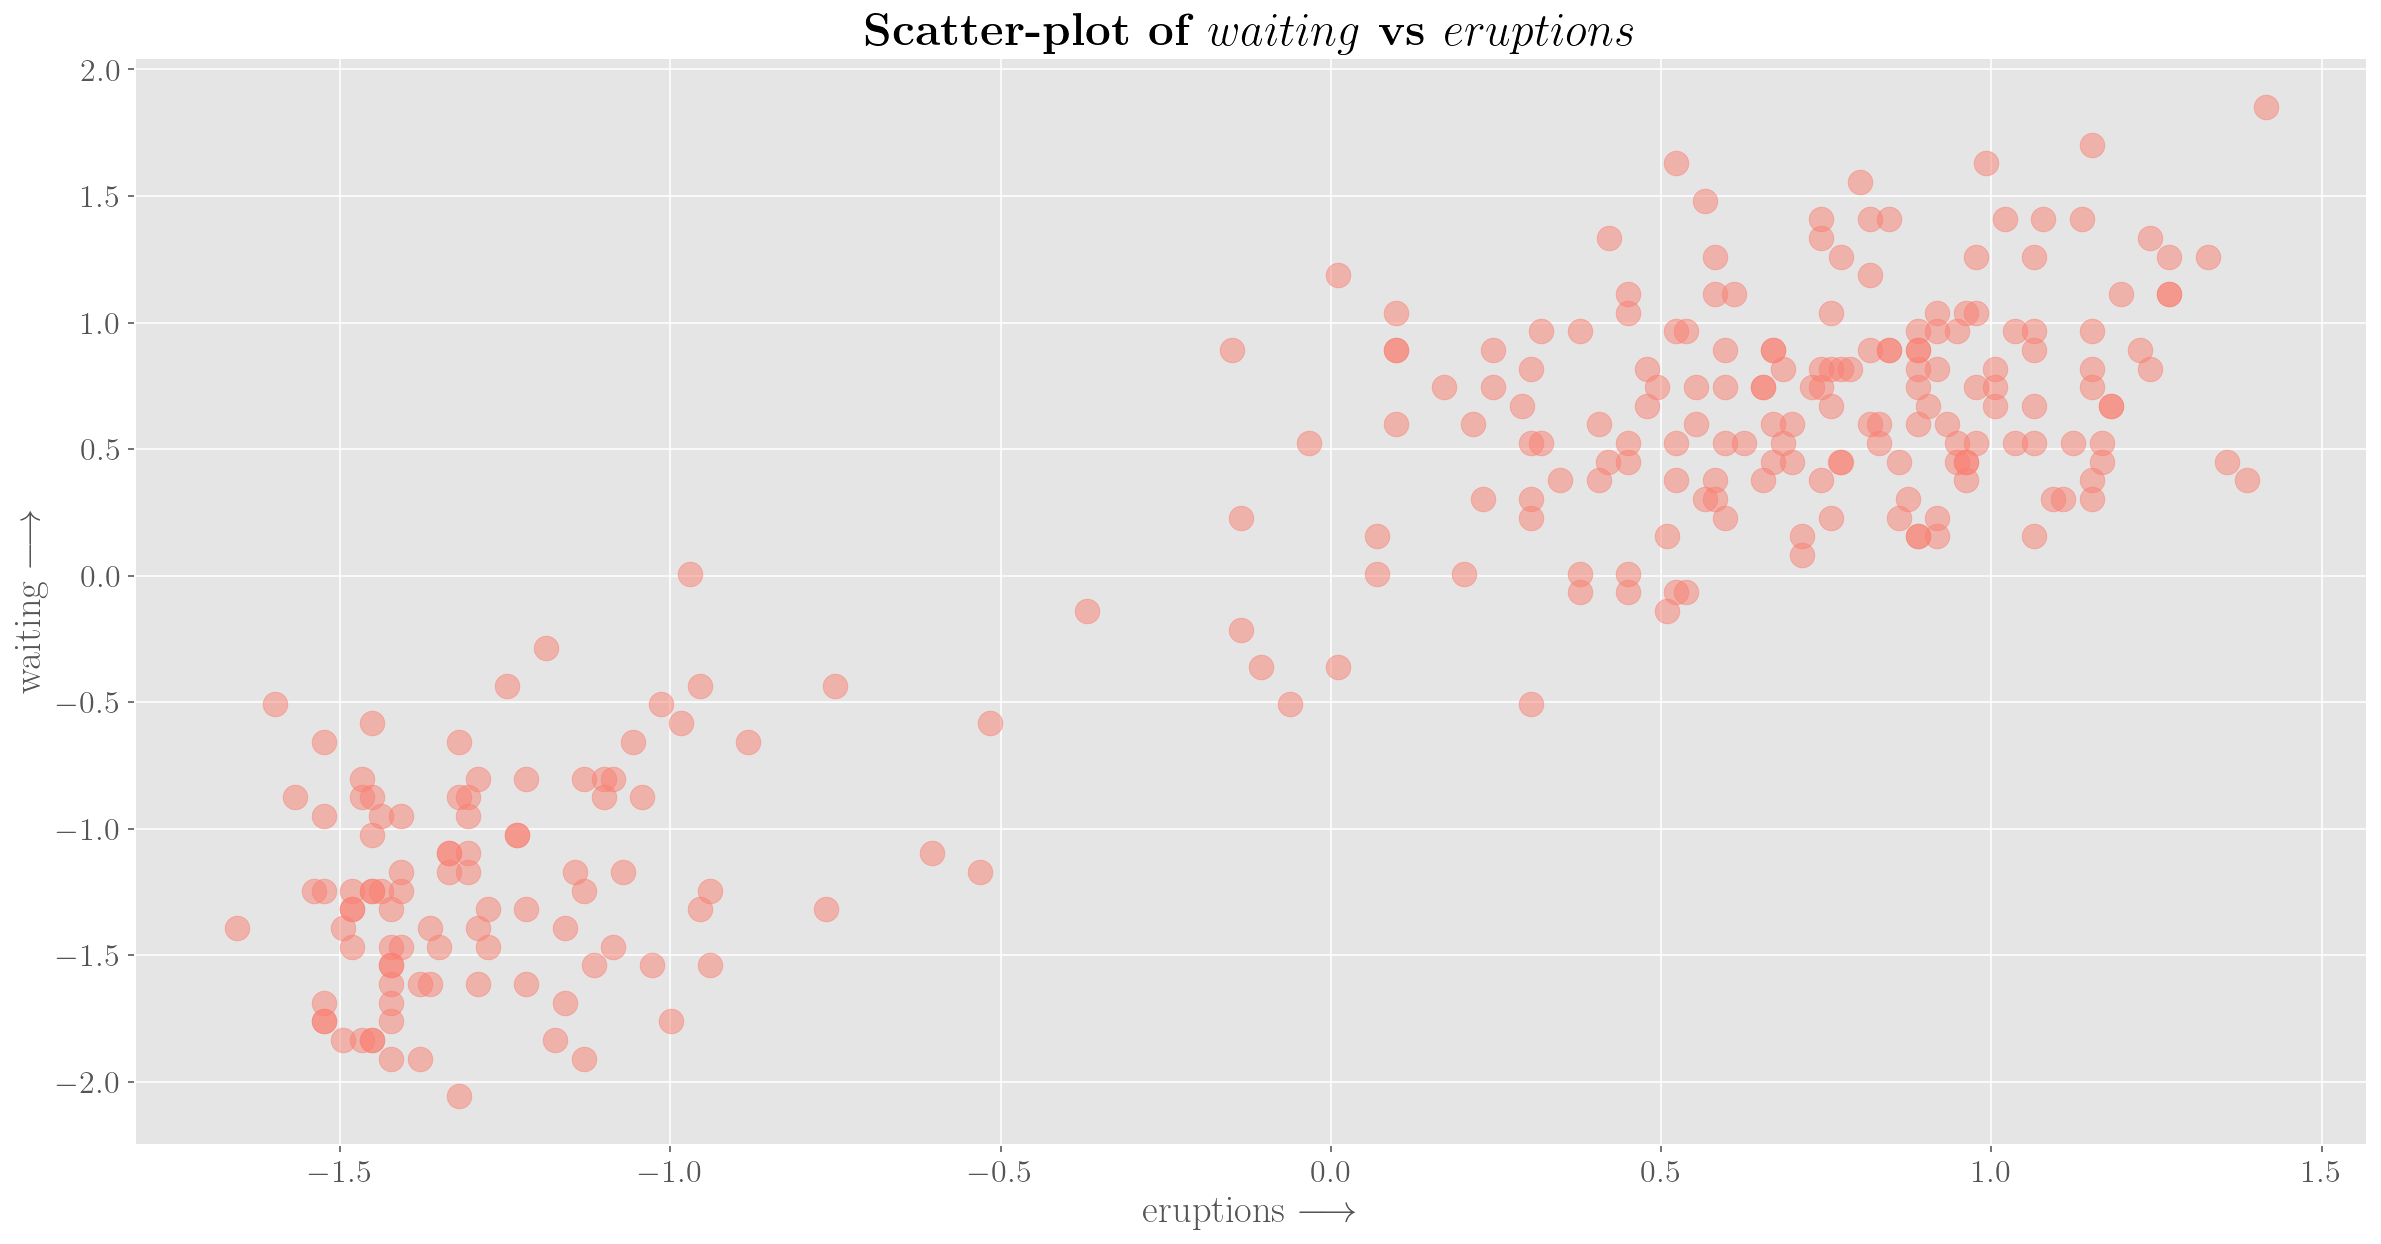

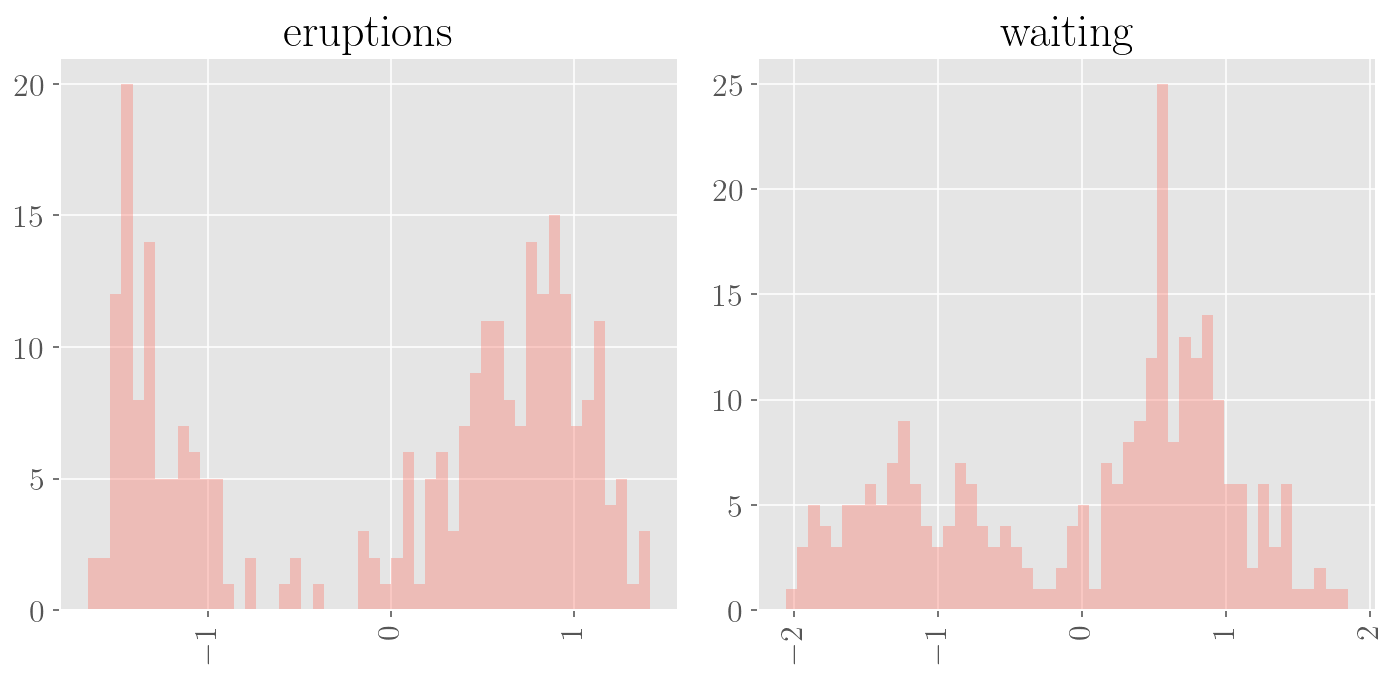

In [15]:
plt.scatter(data['eruptions'], data['waiting'], alpha=0.5, s=150, color='salmon')
plt.title(r'\textbf{Scatter-plot of $waiting$ vs $eruptions$}')
plt.xlabel(r'eruptions $\longrightarrow$');
plt.ylabel(r'waiting $\longrightarrow$');
plt.show();
data.hist(bins=50, alpha = 0.4, color='salmon', xrot=90, figsize=(10,5));
plt.tight_layout()

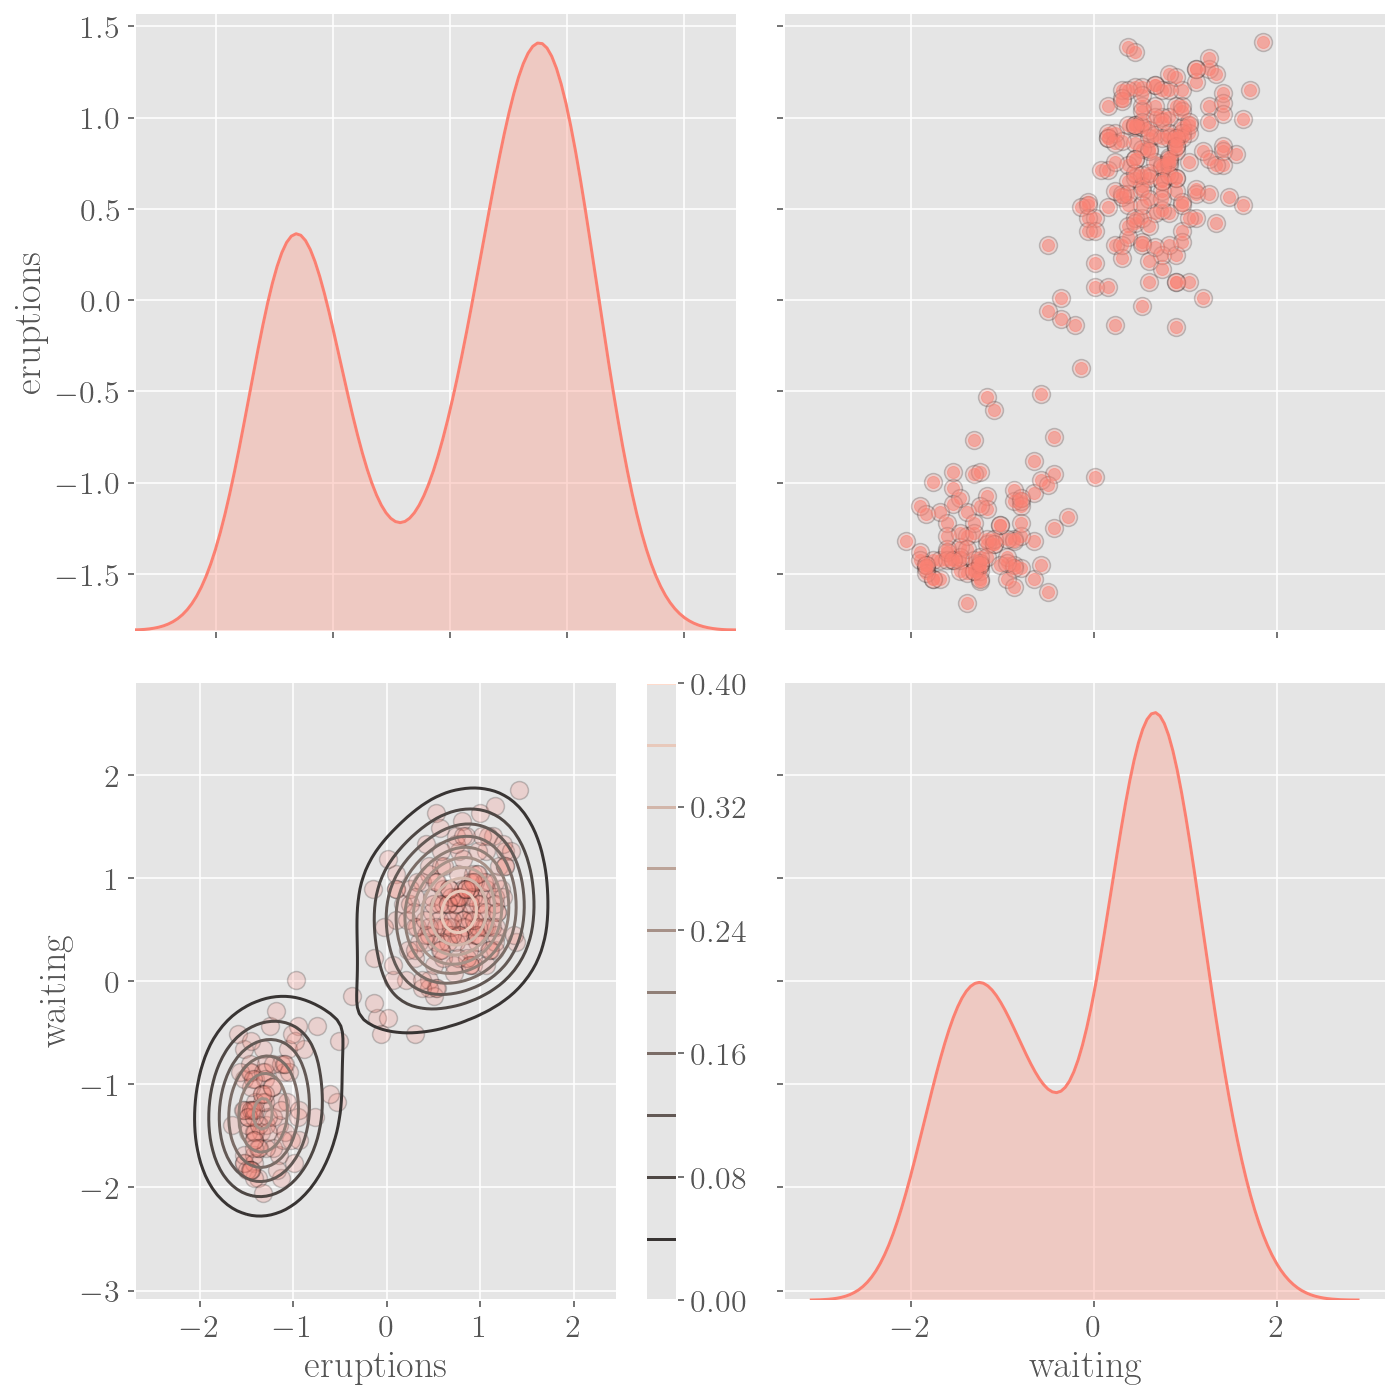

In [16]:
sns.set_palette("Reds")

sample = data
g = sns.pairplot(sample, diag_kind='kde', 
                   plot_kws = { 'alpha': 0.20, 's': 80, 'edgecolor': 'k', 'color':'salmon'}, 
                   size=5, );
g.map_diag(sns.kdeplot, color='salmon',  shade=True);
g.map_upper(plt.scatter, color='salmon', alpha=0.5);
g.map_lower(sns.kdeplot, shade=False, shade_lowest=False, cbar=True);

plt.tight_layout()

## Gradient Descent from first principles

Recall that a step of learning is given by the equation:

\begin{align}\boldsymbol{\beta_\text{next}} &= \boldsymbol{\beta} - \alpha \nabla \mathscr {L(\mathbf\beta)} \\
\text{where} &: \nonumber\\
\boldsymbol{\beta} &: \text{the parameter vector} \begin{pmatrix} \beta_0\\ \beta_1 \end{pmatrix}\nonumber\\
\boldsymbol{\beta_\text{next}} &: \text{the next value of the parameter vector} \nonumber\\
\alpha &: \text{the learning rate} \nonumber\\
\mathscr{L(\mathbf\beta)} &: \text{the loss function}\nonumber\\
\end{align}

Let us consider an ordinary least squares loss function, so that we define the loss as simply the sum-squared errors.

\begin{align}\mathscr{L} &= \sum_{i=1}^n (y_i - \widehat{y}_i)^2\\
&= \sum_{i=1}^n (y_i - \beta_0 -\beta_1 x_i)^2
\end{align}


The expression for the gradient of the loss is, therefore:


\begin{equation}
\nabla \mathscr {L}(\mathbf\beta) = \begin{pmatrix} \frac{\partial L}{\partial\beta_0} \\ \frac{\partial L}{\partial\beta_1} \end{pmatrix} 
\end{equation}


Let us work out each of the component derivatives:

\begin{align}\frac{\partial \mathscr L}{\partial \beta_0} &= - \sum_{i=1}^n (y_i -\beta_0 - \beta_1 x_i)\\
\frac{\partial \mathscr L}{\partial \beta_1} &= - \sum_{i=1}^n x_i(y_i -\beta_0 - \beta_1 x_i)\\
\end{align}

Therefore, the gradient descent step can be expressed as:

\begin{align}
\beta_{0, next} &= \beta_0 + \alpha\sum_{i=1}^n (y_i -\beta_0 - \beta_1 x_i) \\
\beta_{1, next} &= \beta_1 + \alpha\sum_{i=1}^n x_i(y_i -\beta_0 - \beta_1 x_i)
\end{align}


We are going to perform a batch gradient descent, i.e. use all of the training data to compute loss in each step. Let us start with a small learning rate, say $\alpha = 10^{-5}$. We need a stopping criterion for our learning process.

For simplicity, let us stop after say 200 epochs, i.e. running the gradient descent for a two hundred steps.

**Definition: EPOCH**
While training, an epoch is a complete cycle through the entire dataset. In other words, each datum in the dataset should have contributed to the learning in that cycle.

For simple or batch gradient descent, we use all of the data in each cycle; therefore, one step of gradient descent maps to an entire epoch. Later we will learn about other variants of the gradient descent process; in particular, we will learn about stochastic gradient descent, mini-batch gradient descent. We will also learn about various momentum based variants. But that is a topic for a later day.

In [17]:
α = pow(10, -4)
β_0, β_1 =  4, 4 #np.random.normal(0,5,2) # initialize the parameters to some random values.
epochs = 200
X, Y = data['eruptions'].values, data['waiting'].values
α, β_0, β_1, epochs

(0.0001, 4, 4, 200)

In [18]:
intermediates = pd.DataFrame(columns=['epoch', 'β0', 'β1', 'loss'])

for epoch in range(epochs+1):
    
    # compute the gradients
    dβ_0    = -sum([yi - β_0 - β_1*xi for xi, yi in zip (X, Y)]) 
    dβ_1    = -sum([xi*(yi - β_0 - β_1*xi) for xi, yi in zip (X, Y)])
    
    # gradient descent step
    β_0     = (β_0 - α*dβ_0)
    β_1     = (β_1 - α*dβ_1)
    
    # update the loss function
    loss    = sum([ (yi -β_0 -β_1*xi)**2 for xi, yi in zip (X, Y)])
    
    # store the values for later visualization
    intermediates.loc[intermediates.shape[0]] = [epoch, β_0, β_1, loss]

Let us preview some of the rows of data.

In [19]:
pd.set_option("display.precision", 3)     
intermediates

,epoch,β0,β1,loss
0,0.0,3.891,3.916,6642.116
1,1.0,3.785,3.834,6288.451
2,2.0,3.682,3.754,5953.763
3,3.0,3.582,3.676,5637.035
4,4.0,3.485,3.601,5337.303
...,...,...,...,...
196,196.0,0.017,0.914,51.416
197,197.0,0.017,0.914,51.409
198,198.0,0.017,0.914,51.402
199,199.0,0.016,0.913,51.395


## Parameter optimization with epochs

Let us now see how the learning of the parameters $\beta_0$ and $\beta_1$ happens with each epoch.

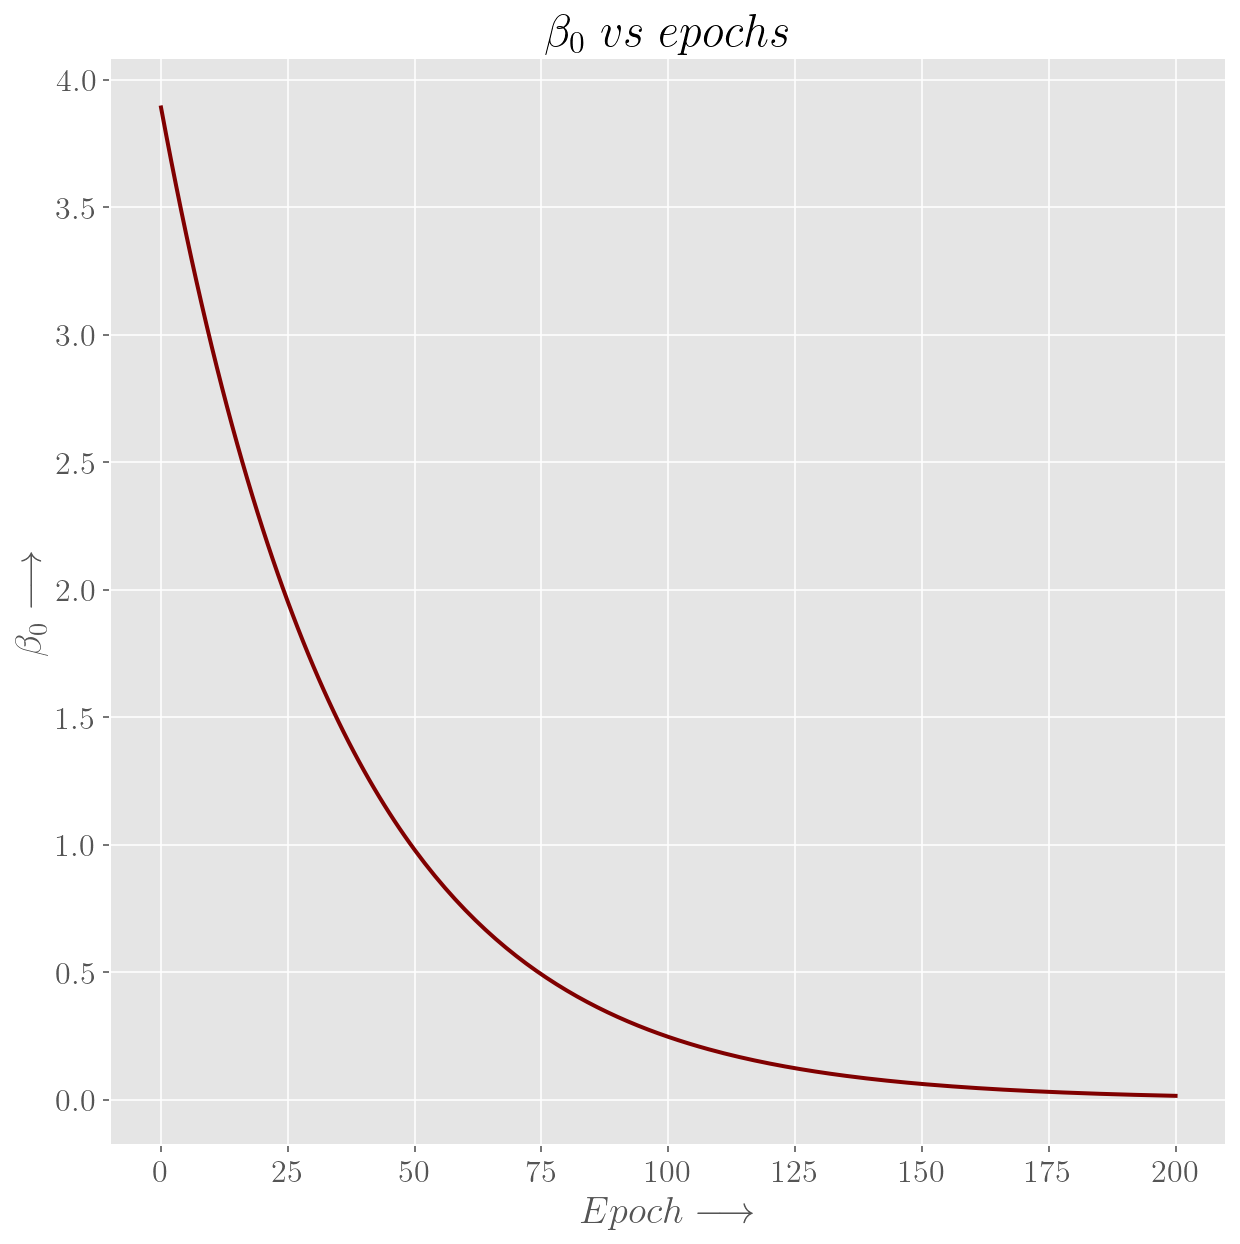

In [20]:
plt.figure(figsize=(10,10))
plt.plot(intermediates.epoch, intermediates.β0, linewidth=2, alpha=1, color='maroon');
plt.xlabel(r'$Epoch\longrightarrow$');
plt.ylabel(r'$\beta_0\longrightarrow$');
plt.title(r"""$\beta_0\ vs\ epochs$""");

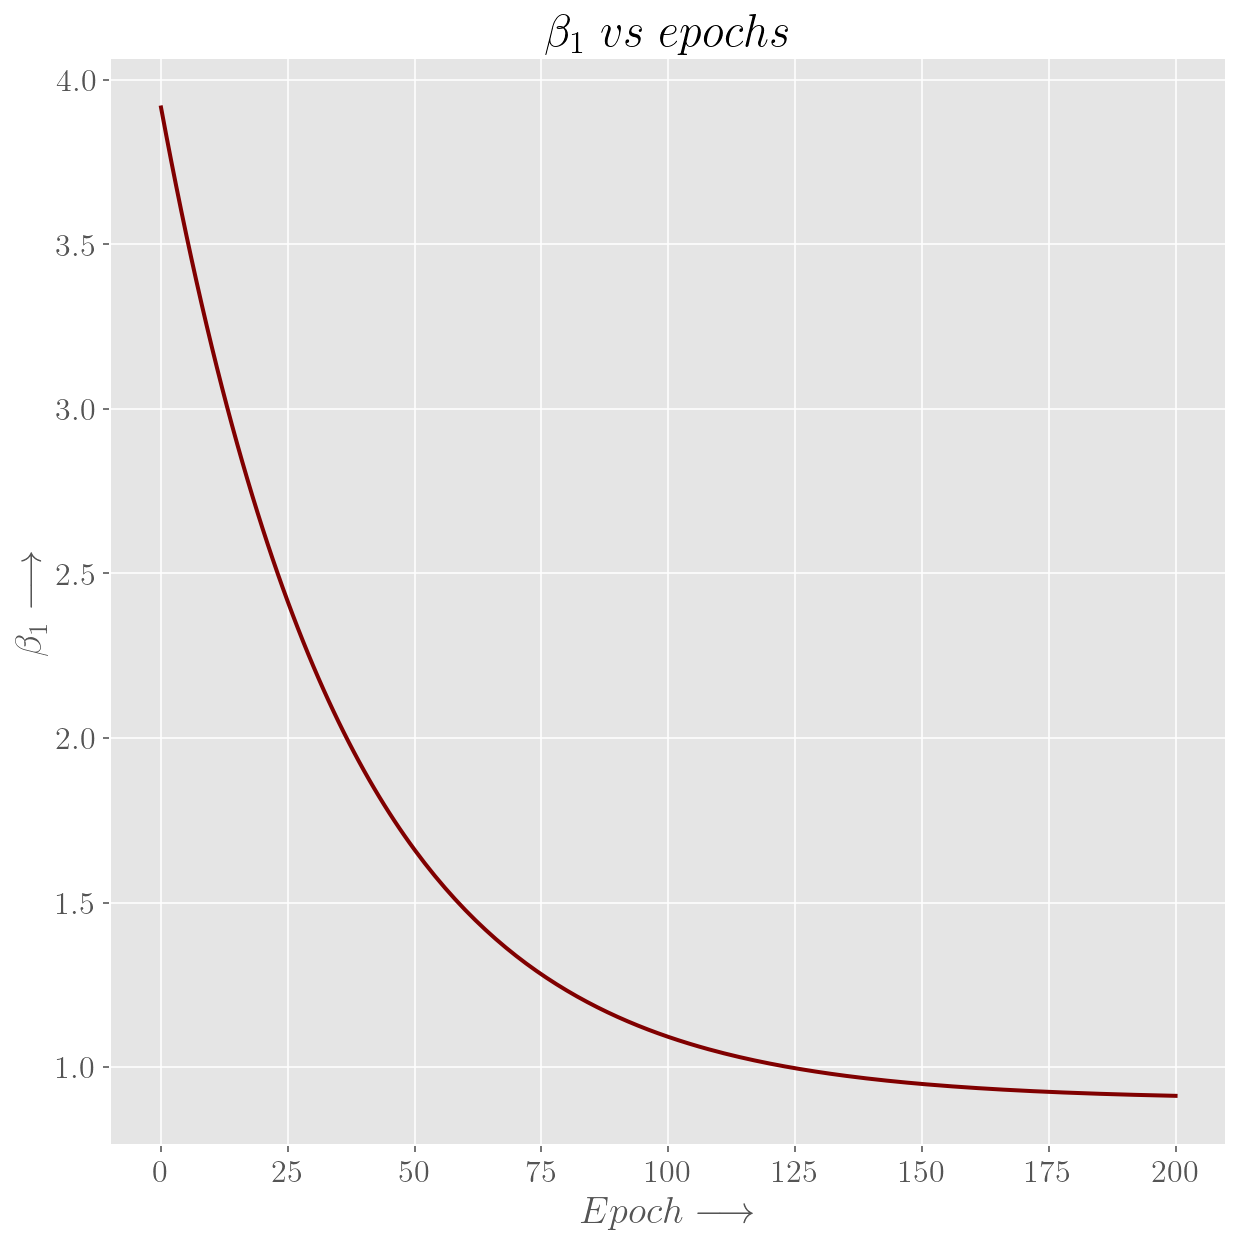

In [21]:
plt.figure(figsize=(10,10))
plt.plot(intermediates.epoch, intermediates.β1, linewidth=2, alpha=1, color='maroon');
plt.xlabel(r'$Epoch\longrightarrow$');
plt.ylabel(r'$\beta_1\longrightarrow$');
plt.title(r"""$\beta_1\ vs\ epochs$""");

Also, let us see how the loss (sum squared errors) decreased with the epochs.

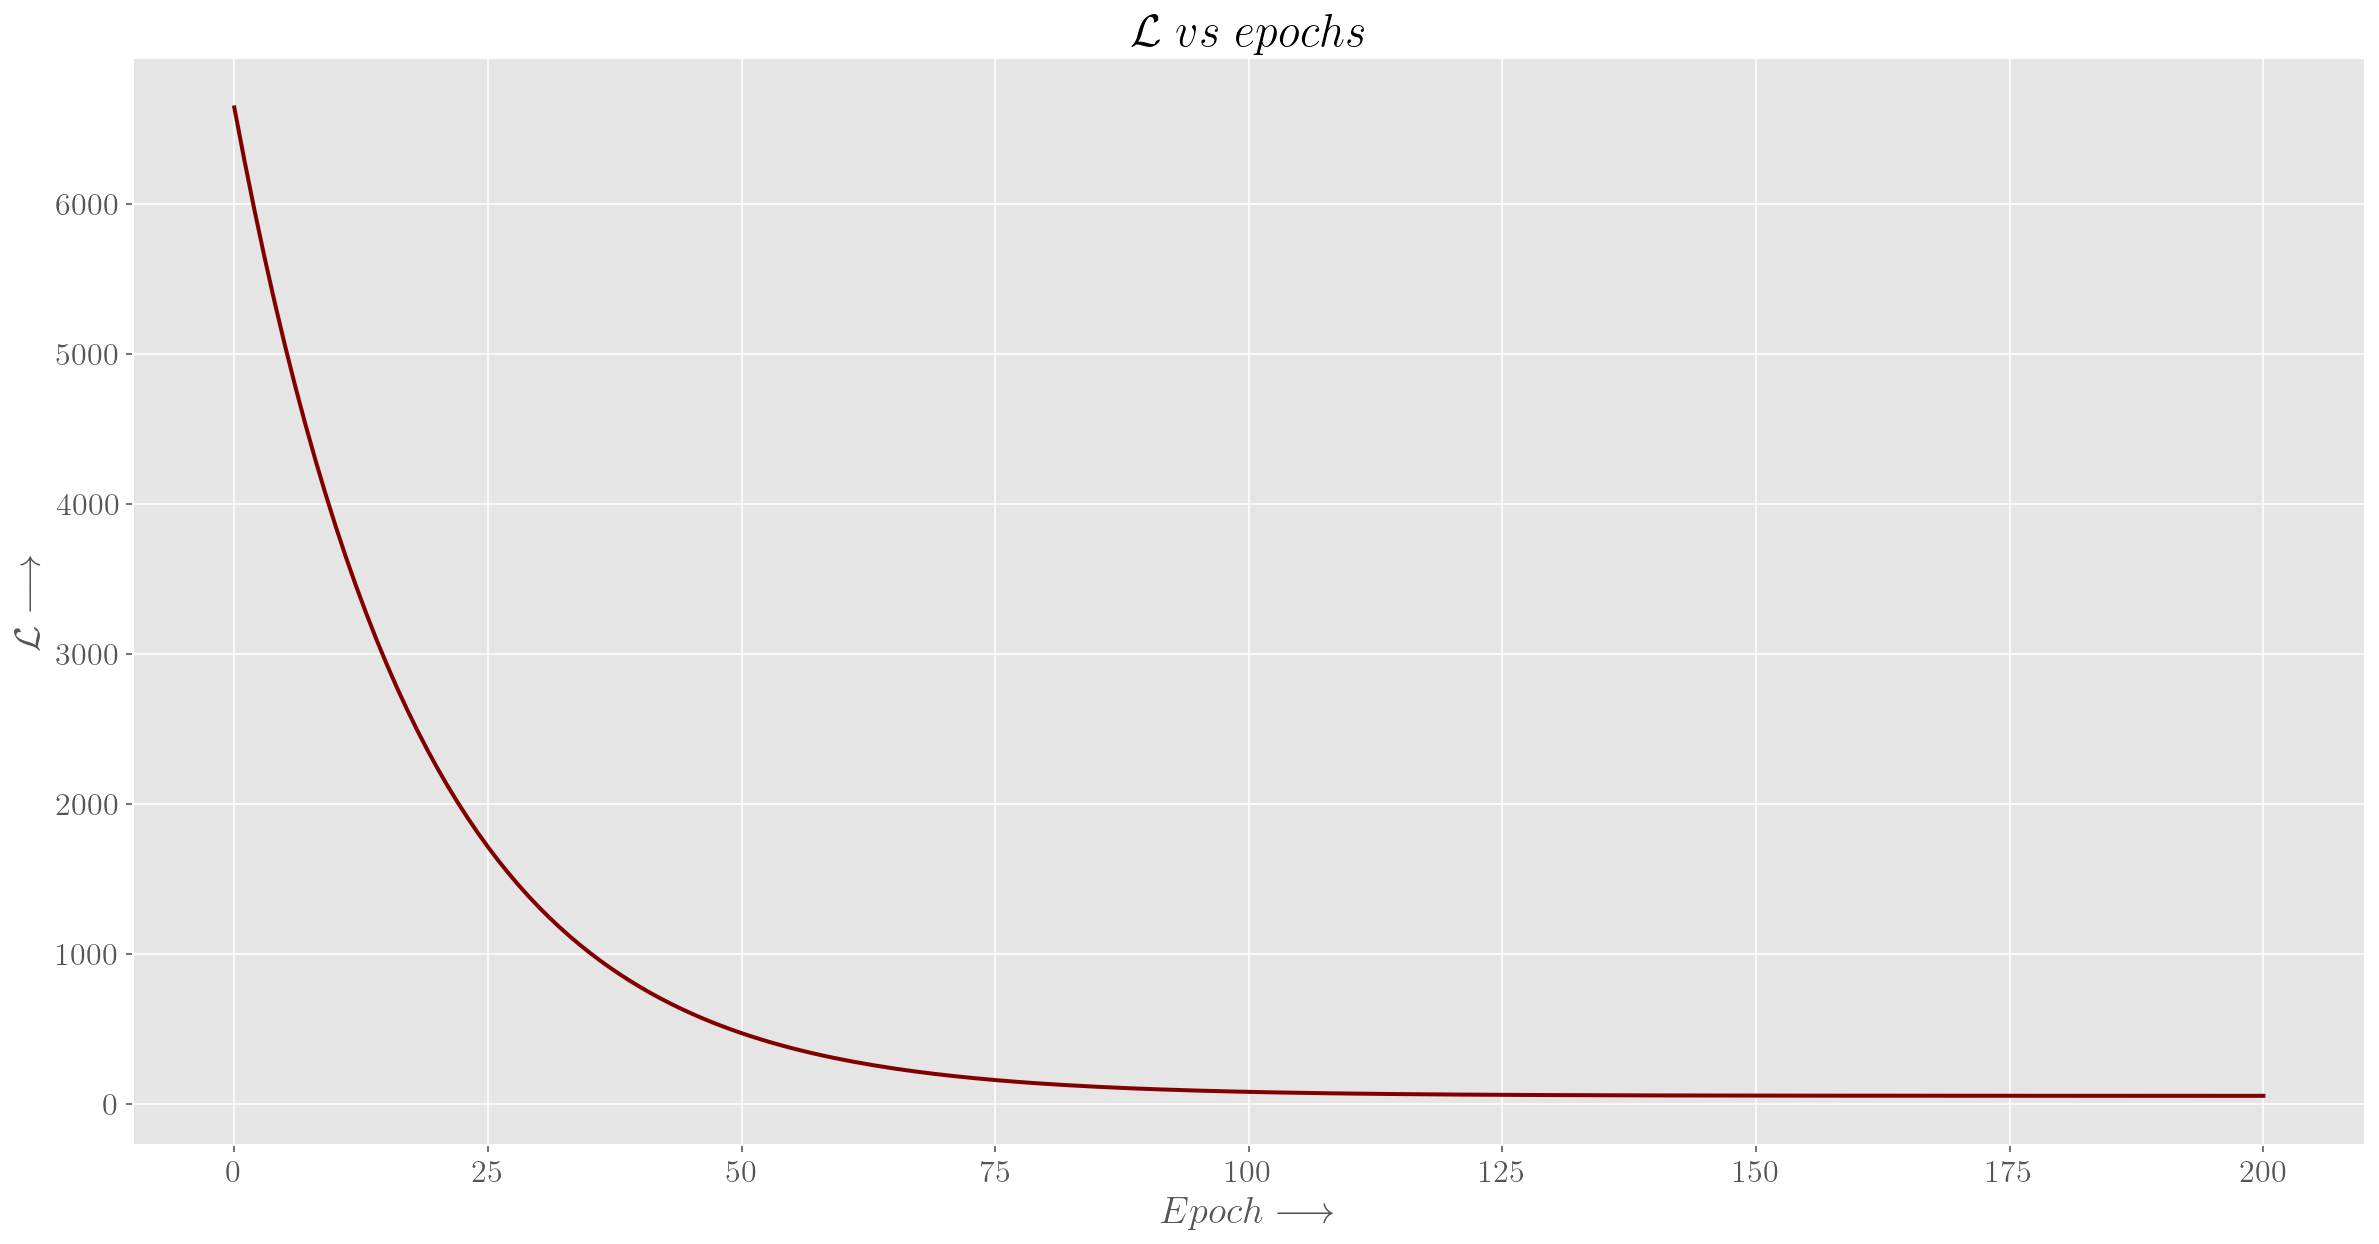

In [22]:
plt.figure(figsize=(20,10))
plt.plot(intermediates.epoch, intermediates.loss, linewidth=2, alpha=1, color='maroon');
plt.xlabel(r'$Epoch\longrightarrow$');
plt.ylabel(r'$\mathcal L\longrightarrow$');
plt.title(r"""$\mathcal L\ vs\ epochs$""");

## Loss contour plots in the parameter space

Let us start by creating a grid mesh of points in the hypothesis space, each point corresponding to a particular hypothesis's parameter value $\boldsymbol\beta = \begin{pmatrix}\beta_0 \\ \beta_1 \end{pmatrix}$. Next, let us compute the value of the loss function, $\mathscr{L}$, as the sum-squared errors at each of these points.

### Loss Contour plot

In [23]:
def loss(β0:float, β1:float) -> float:
     return sum ([(yi - β0 -β1*xi)**2 for xi,yi in zip(X, Y)])

# Create the mesh grid of values.
b0     = np.linspace(-4, 4, 1000)
b1     = np.linspace(-4,4,1000)
B0, B1 = np.meshgrid(b0, b1)
rss    = loss(B0, B1)

Let us look at the contour surfaces (curves of equal loss or errors). Because we had standardized the data, the contour plot is elliptic will low eccentricity, i.e. almost circular; however, because we have drawn the plot in a 2:1 ratio, it looks more elliptical than it is. Change the plot size below to a square (20,20) for the figure size, and see what happens.

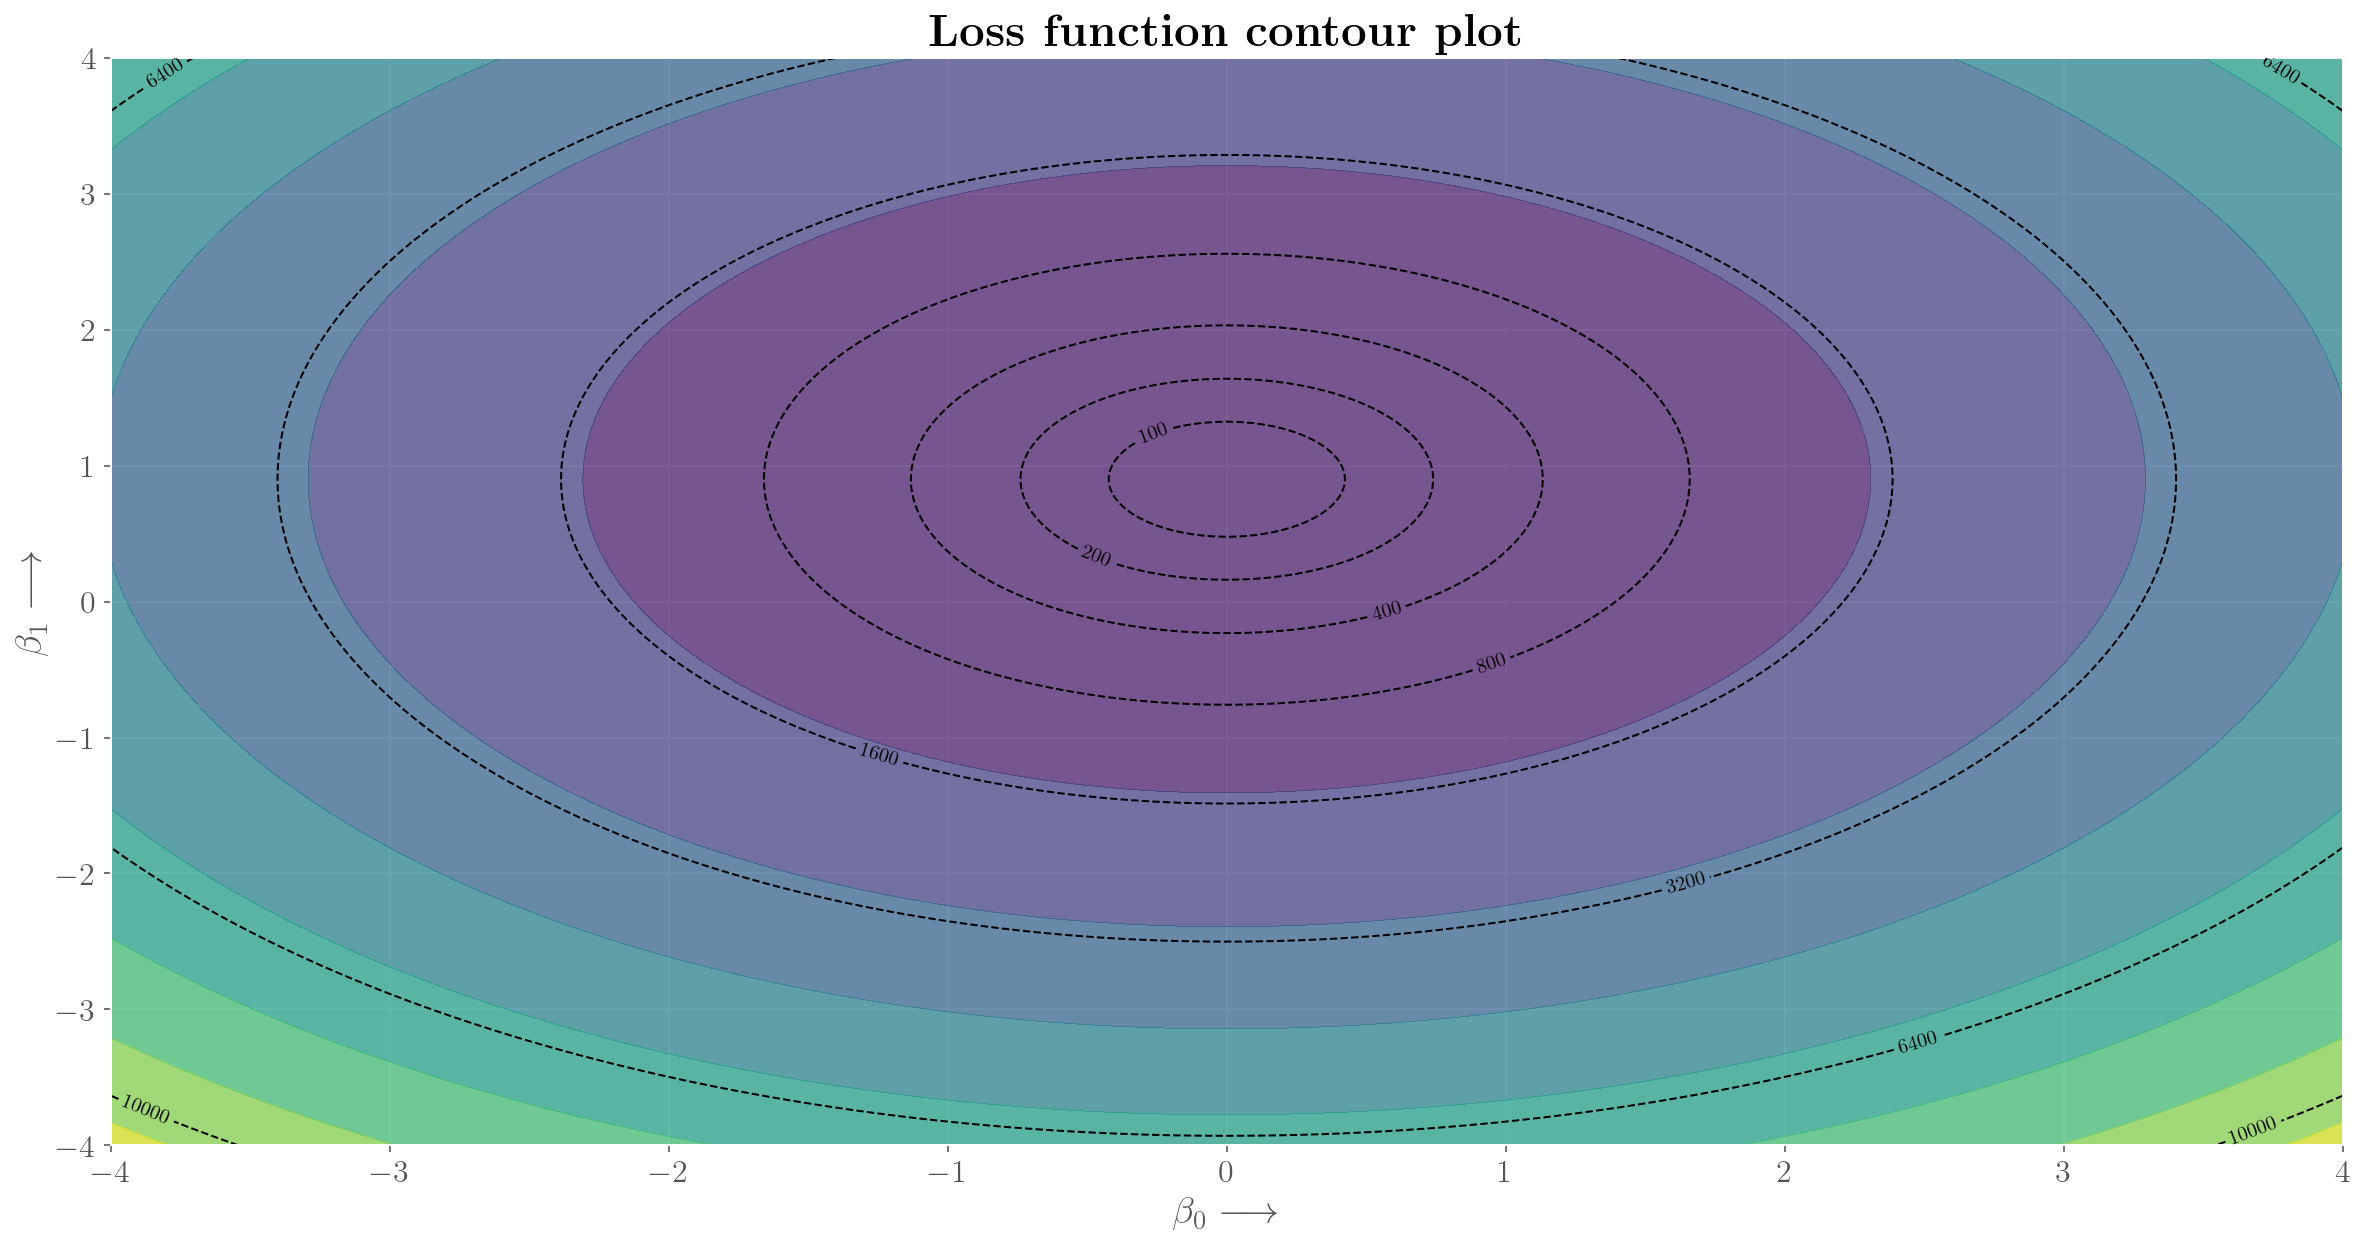

In [24]:
levels=[0, 50, 100, 200, 400, 800, 1600, 3200, 6400, 10_000]
plt.figure(figsize=(20,10))
contour_plot = plt.contour(B0, B1, rss, levels, colors='black', linestyles='dashed', linewidths=1, )
plt.clabel(contour_plot, inline=1, fontsize=10)
contour_plot = plt.contourf(B0, B1, rss,alpha=0.7)
plt.xlabel(r'$\beta_0\longrightarrow$');
plt.ylabel(r'$\beta_1\longrightarrow$');
plt.title(r'\textbf{Loss function contour plot}');

### Loss surface and the contour plots in the parameter plane ($\boldsymbol \beta$-hyperplane)

Let us see the relationship between the loss surface, and its projection on the $\boldsymbol \beta$-hyperplane. 

**Note: in order to show the loss surface above the contour plot, we have artificially added 2000 to the residual loss, in order to lift the loss surface. To see the correct loss surface, reset the `loss_lift` to zero**

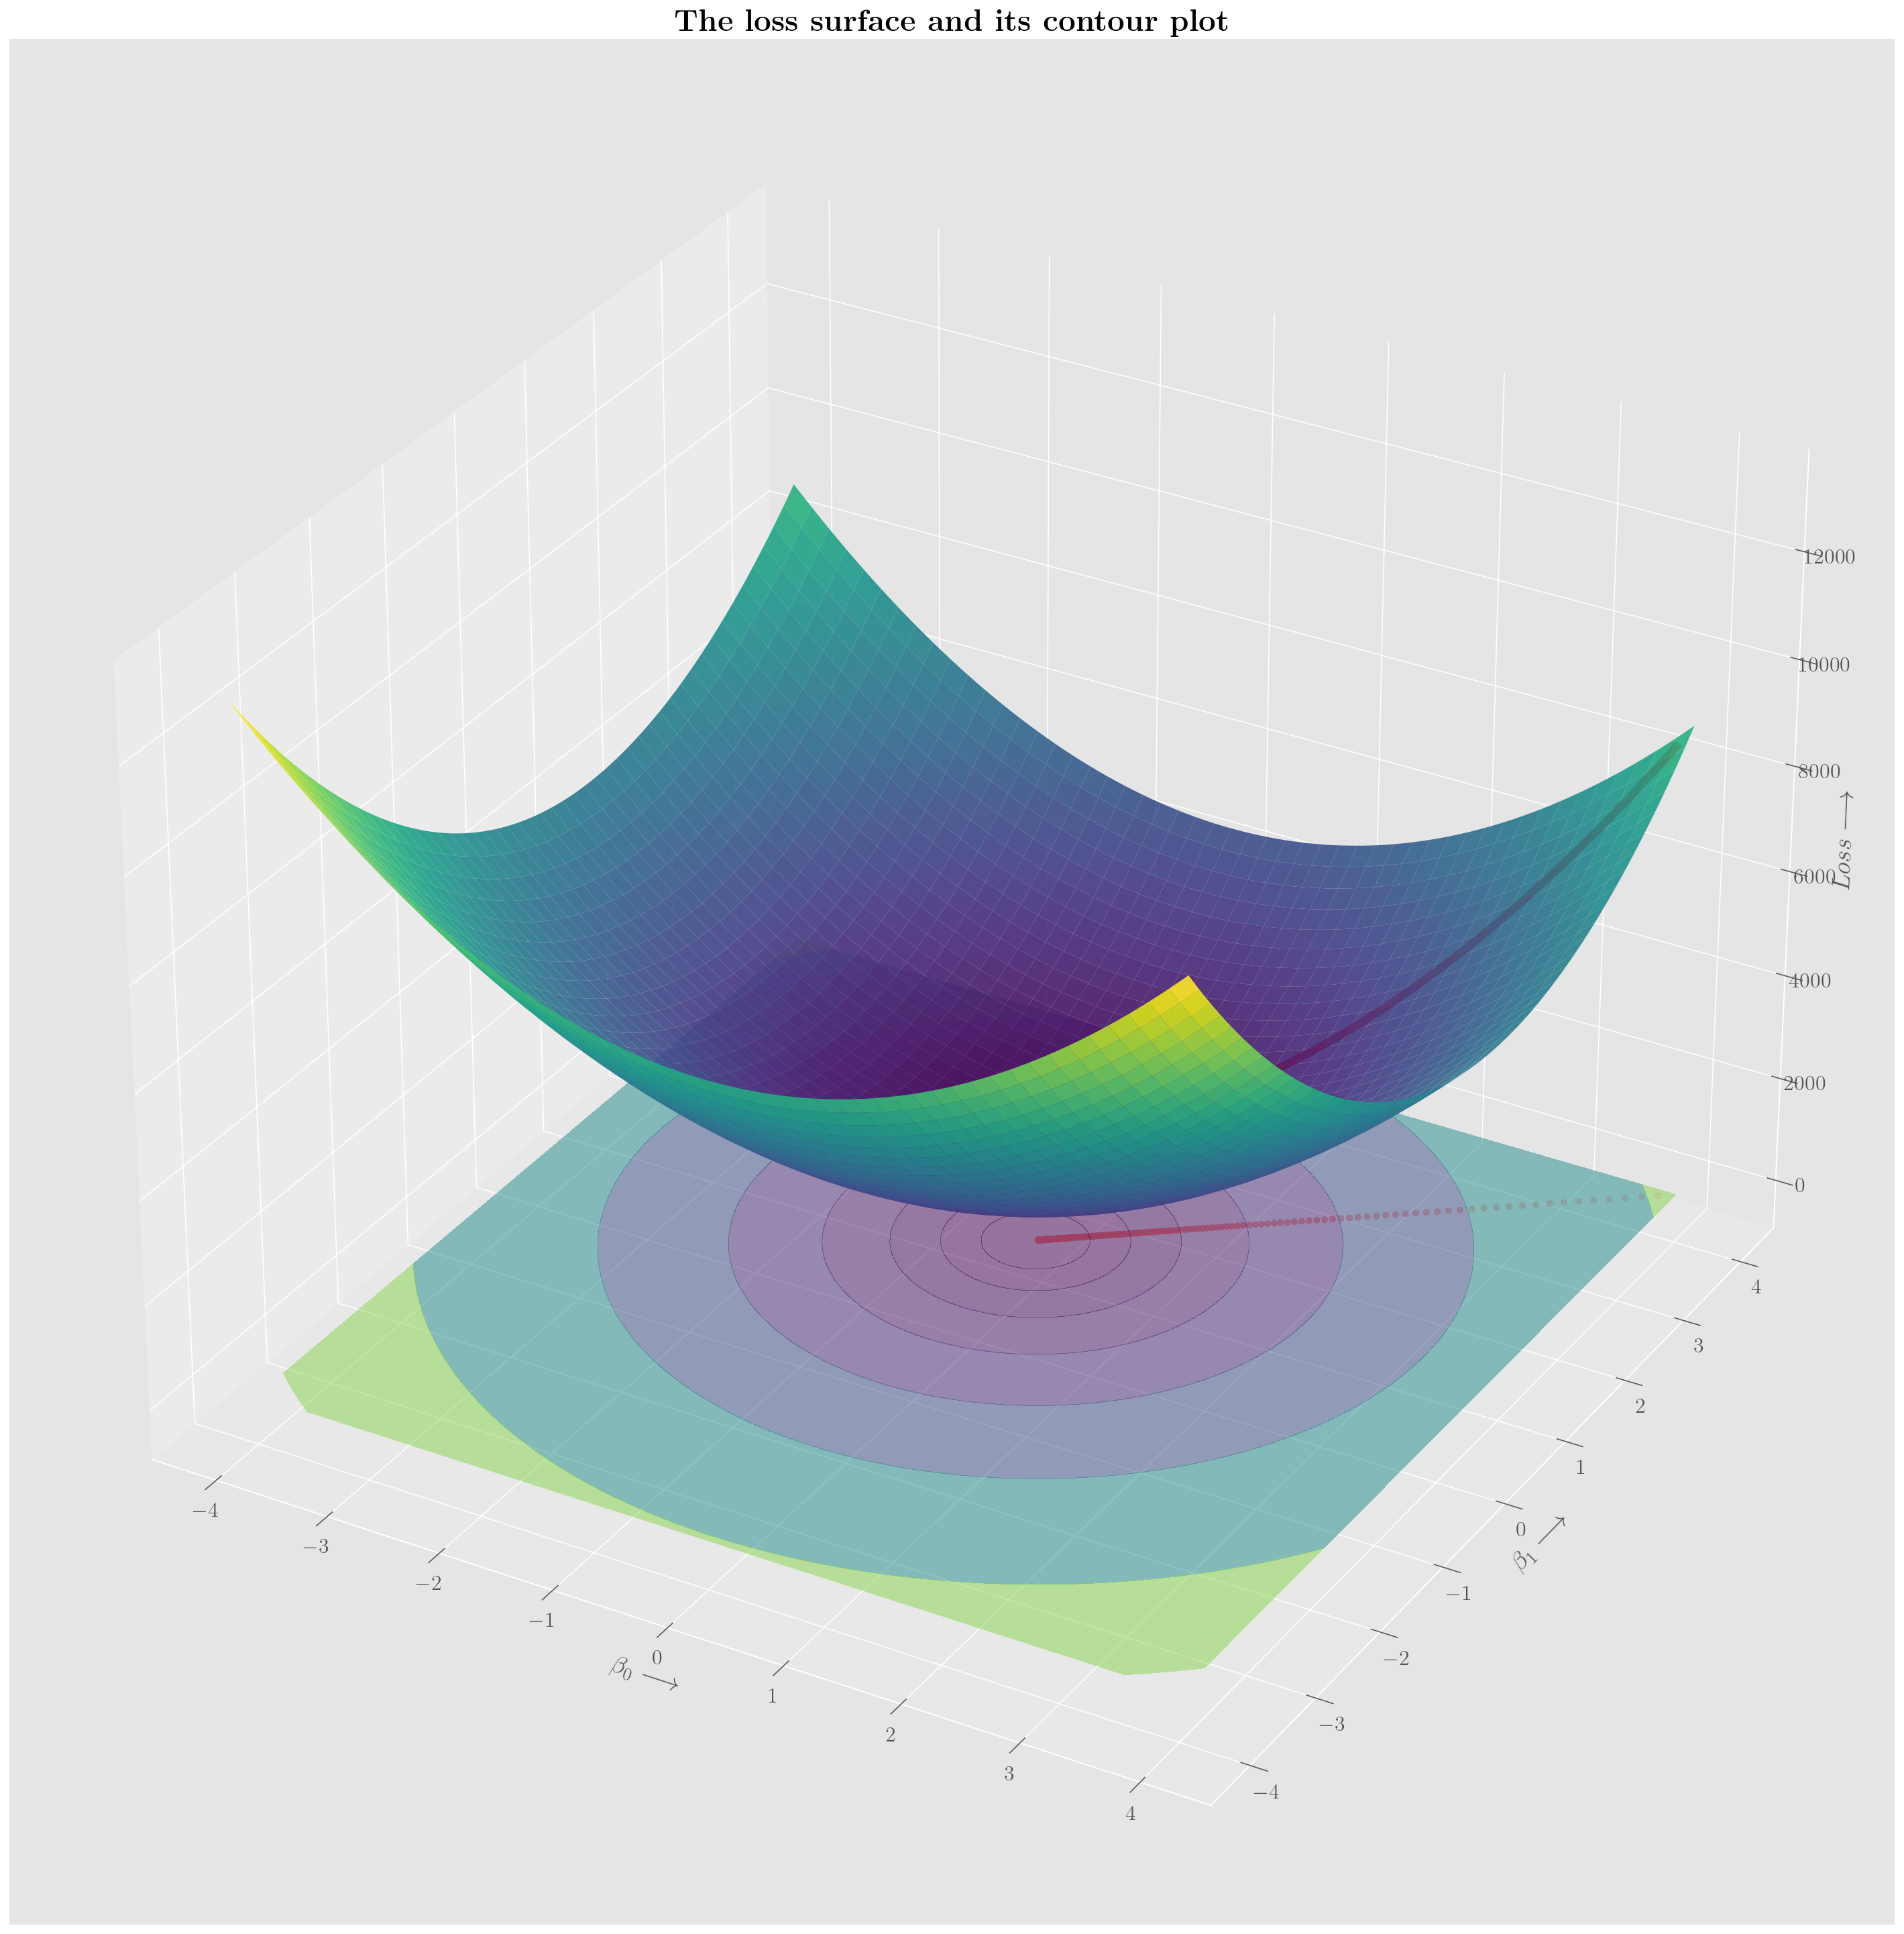

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(111, projection='3d')
loss_lift = 2000 # artificially lifing the loss surface to better show the contour plot below it.

#Plot the loss surface
ax.plot_surface(B0, B1, loss_lift + (rss),
                cmap='viridis', alpha=0.9);

levels=[0, 100, 200, 400, 800, 1600, 3200, 6400, 10_000]

# Plot the contours
ax.contourf(B0, B1, rss, levels, offset = 0, alpha=0.5)
plt.xlabel(r'$\beta_0\longrightarrow$');
plt.ylabel(r'$\beta_1\longrightarrow$');
ax.set_zlabel(r'$Loss\longrightarrow$');

# Plot the learning journey
ax.plot(intermediates.β0, intermediates.β1, intermediates.loss + loss_lift,  color='red',zdir='z', linewidth=6)
ax.scatter(intermediates.β0, intermediates.β1, s=20,  color='salmon',zdir='z')
plt.title(r'\textbf {The loss surface and its contour plot}');
plt.tight_layout()

## GRADIENT DESCENT ANIMATION

Let us create an animation to show the progression of learning with gradient descent. In the video below, the process of gradient descent is shown as the gradual optimization takes place.

*Caution: This code below to generate the animation can be computationally very intensive and take quite some time to finish. The value of the loop has deliberately been set to zero, so that you don't accidentally run it.*

If you want to run it, uncomment the line of code below that sets the variable `iterations`

In [ ]:
from celluloid import Camera
fig = plt.figure(figsize=(20,30))
camera = Camera(fig)

from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
loss_lift = 2000 

iterations = 0                          # for safety, that this code does not accidentally get run.
#iterations = intermediates.shape[0]+1  # uncomment this if you want to generate a new animation video.
# Plot the learning journey
for i in range(iterations):
    ax.plot_surface(B0, B1, loss_lift + (rss),
                cmap='viridis', alpha=0.9);

    levels=[0, 100, 200, 400, 800, 1600, 3200, 6400, 10_000]

    ax.contourf(B0, B1, rss, levels, offset = 0, alpha=0.5)
    plt.xlabel(r'$\beta_0\longrightarrow$');
    plt.ylabel(r'$\beta_1\longrightarrow$');
    ax.set_zlabel(r'$Loss\longrightarrow$');
    subset = intermediates.head(i+1)
    ax.plot(subset.β0, subset.β1, subset.loss + loss_lift,  color='red',zdir='z', linewidth=6)
    ax.plot(subset.β0, subset.β1, linewidth=6,  color='salmon',zdir='z')
    plt.title(r'\textbf {The loss surface and its contour plot}');
    plt.tight_layout()
    camera.snap()

animation = camera.animate()
animation.save('animation-gradient-descent.mp4')

In [2]:
%%html
<video width="1000px" controls loop>
  <source src="https://raw.githubusercontent.com/supportvectors/ml-100/master/animated-gradient-descent.mp4" type="video/mp4">
</video>